<a href="https://colab.research.google.com/github/forowho/Dendritic-and-non_Dendritic-Micrograph-Classification/blob/main/11_Dendritic_and_non_Dendritic_augmented_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import keras
import cv2
import os
import glob
%matplotlib inline
import shutil
from shutil import copyfile
import random
import time
import cv2

# tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# sklearn Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Metrics Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Import dataset from google drive

In [2]:
# Download dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip

--2024-10-19 20:51:31--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.108.8, 3.5.67.189, 52.218.24.232, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.108.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111332105 (106M) [application/octet-stream]
Saving to: ‘nyb6mycvfd-1.zip’

nyb6mycvfd-1.zip    100%[===================>] 106.17M  12.4MB/s    in 22s     

2024-10-19 20:51:54 (4.90 MB/s) - ‘nyb6mycvfd-1.zip’ saved [111332105/111332105]



In [3]:
#unzip the dataset
!unzip -q /content/nyb6mycvfd-1.zip

# Image augmentation

In [4]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
#from tensorflow.keras.utils import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range =15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         rescale=1./255,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip = True,
                         fill_mode = 'nearest',
                         data_format='channels_last',
                         brightness_range=[0.5, 1.5])

In [5]:
# prompt: generate code to create two folders and name it Augment_Dendrite and Augment_Non_Dendrite

try:
  os.mkdir('Augment_Dendrite')
except:
  print("Folder already exists")

try:
  os.mkdir('Augment_Non_Dendrite')
except:
  print("Folder already exists")

In [6]:
img_dir_Den = "/content/Dendritic" # Enter Directory of all images
data_path = os.path.join(img_dir_Den,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break



In [7]:
img_dir_Non_Den = "/content/Non-Dendritic" # Enter Directory of all images
data_path_N = os.path.join(img_dir_Non_Den,'*g')
files = glob.glob(data_path_N)
data_N = []
for f1 in files:
    img = cv2.imread(f1)
    data_N.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Non-Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Non_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break


## Image preprocessing

In [8]:
# set path to dendritic micrograph images
dendritic_dir = '/content/Augment_Dendrite'
# set path to non dendritic micrograph images
non_dendritic_dir = '/content/Augment_Non_Dendrite'

#Print the total number of images in each directory
print("The total number of dendritic images are", len(os.listdir(dendritic_dir)))
print("The total number of non dendritic images are", len(os.listdir(non_dendritic_dir)))

The total number of dendritic images are 2142
The total number of non dendritic images are 5636


In [9]:
# Data Visualization
import matplotlib.image as mpimg

# Setting the no of rows and columns
ROWS = 4
COLS = 4

# Setting the figure size
fig = plt.gcf()
fig.set_size_inches(12, 12)

# get the directory to each image file in the trainset
non_dendritic_pic = [os.path.join(non_dendritic_dir, i) for i in os.listdir(non_dendritic_dir)[:8]]
dendritic_pic = [os.path.join(dendritic_dir, i) for i in os.listdir(dendritic_dir)[:8]]

<Figure size 1200x1200 with 0 Axes>

In [10]:
# merge dedritic and non_dendritic images
merged_list = dendritic_pic + non_dendritic_pic
print("The total number of images in the merged list are", len(merged_list))

The total number of images in the merged list are 16


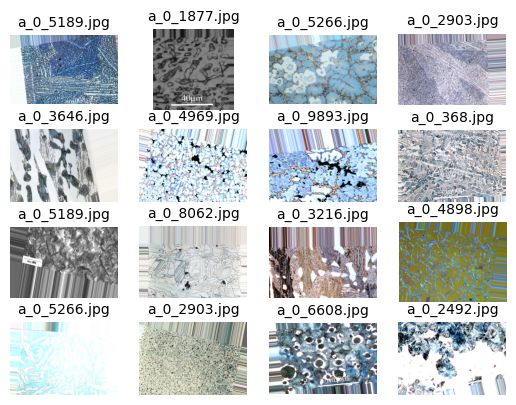

In [11]:
# Plotting the images in the merged list
for i, img_path in enumerate(merged_list):
    # getting the filename from the directory
    data = img_path.split('/', 7)[3]
    # creating a subplot of images with the no. of rows and colums with index no
    sp = plt.subplot(ROWS, COLS, i+1)
    # turn off axis
    sp.axis('Off')
    # reading the image data to an array
    img = mpimg.imread(img_path)
    # setting title of plot as the filename
    sp.set_title(data, fontsize=10)
    # displaying data as image
    plt.imshow(img, cmap='gray')

plt.show()  # display the plot

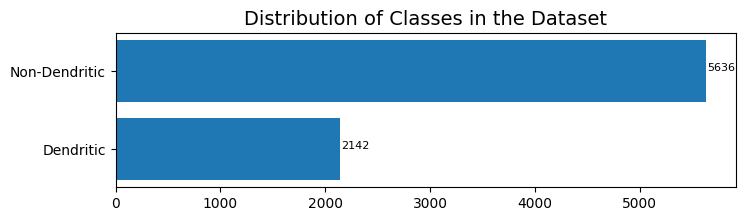

In [12]:
# Plot class distribution
plt.figure(figsize=(8,2))
x = np.arange(2)
y = [len(os.listdir(dendritic_dir)), len(os.listdir(non_dendritic_dir))]
plt.barh(x, y)
plt.yticks(x, ["Dendritic", "Non-Dendritic"], fontsize=10)
plt.text(y[0]+5, x[0], y[0], fontsize=8)
plt.text(y[1]+5, x[1], y[1], fontsize=8)
plt.title("Distribution of Classes in the Dataset", fontsize=14);

# Create the training and validation directories.
Move 80% of the data to the training directory for each class.

In [13]:
try:
  os.mkdir('main_dir')
except:
  print("Folder already exists")

In [14]:
# Move Dendritic folder
try:
  shutil.move('/content/Augment_Dendrite', '/content/main_dir')
except:
  print("Folder already exists")

# Move Non-Dendritic folder
try:
  shutil.move('/content/Augment_Non_Dendrite', '/content/main_dir')
except:
  print("Folder already exists")

In [15]:
main_dir = '/content/main_dir'

In [16]:
! pip install split-folders

In [17]:
import splitfolders
import os
print(os.listdir('/content/main_dir'))
splitfolders.ratio('/content/main_dir', output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

['Augment_Non_Dendrite', 'Augment_Dendrite']


Copying files: 7778 files [00:11, 702.70 files/s]


In [18]:
output = '/content/output'
# Create "training" and "validation" directories
training_dir = os.path.join(output, "train")
validation_dir = os.path.join(output, "val")

In [19]:
tf.keras.preprocessing.image.ImageDataGenerator()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Creat data generator

In [21]:
data_gen_train = ImageDataGenerator(rescale=1/255.0)
data_gen_test = ImageDataGenerator(rescale=1/255.0)

In [22]:
train_generator = data_gen_train.flow_from_directory(training_dir,target_size=(128,128),batch_size=128,class_mode='binary')

Found 6221 images belonging to 2 classes.


In [23]:
test_generator = data_gen_test.flow_from_directory(validation_dir,target_size=(128,128),batch_size=128,class_mode='binary')

Found 1557 images belonging to 2 classes.


In [24]:
train_size = train_generator.n
val_size = test_generator.n
sample_count = train_size + val_size
print("The train_size is ",train_size)
print("The val_size is ", val_size)
print("The total sample_count is ", sample_count)

The train_size is  6221
The val_size is  1557
The total sample_count is  7778


# Model building

In [25]:
# Load VGG19
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# Freeze VGG19 layers
# conv_base.trainable = False

conv_base.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#reshaping the image
img_shape = (150,150,3)

In [27]:
#Model frezing (to enable us apply them on our own custom task)
conv_base.trainable = False

## Defining the transfer learning model

## Extracting features from VGG19

In [28]:
#input layer  = [(None, 150, 150, 3)]
#target_size=(150, 150)
#last layer =  maxpooling  = (None, 4, 4, 512)
#shape=(sample_count, 4, 4, 512)

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16

def extract_features(directory, sample_count):
  '''Function to extract features from images, given the directory of the images and the sample count

  Parameters:
  -----------

  directory: str, this is the directory to the different classes of images
  sample_count: int, this is the total number of samples images

  Returns:
  --------
  features (numpy array) and the corresponding label (numpy array)

  '''
  features = np.zeros(shape=(sample_count, 4, 4, 512))  # Must be equal to the output of the convolutional base
  labels = np.zeros(shape=(sample_count))
  # Preprocess data
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size = batch_size,
                                          class_mode='binary')
  # Pass data through convolutional base
  i = 0
  for inputs_batch, labels_batch in generator:
      features_batch = conv_base.predict(inputs_batch)
      features[i * batch_size: (i + 1) * batch_size] = features_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1
      if i * batch_size >= sample_count:
          break
  return features, labels

start = time.time()  # record start time
train_features, train_labels = extract_features(training_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, val_size)
end = time.time()  # record end time
print('The execution time is:', (end-start) * 10**3, 'ms')

Found 6221 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━

In [29]:
# Reshape training data and validation
train_features = train_features.reshape(train_size, 4*4*512)
validation_features = validation_features.reshape(val_size, 4*4*512)

# save to csv file
np.savetxt('X_train_dendrite.csv', train_features, delimiter=',')
np.savetxt('X_val_dendrite.csv', validation_features, delimiter=',')
np.savetxt('y_train_dendrite.csv', train_labels, delimiter=',')
np.savetxt('y_val_dendrite.csv', validation_labels, delimiter=',')

In [30]:
# clear backend session of tf
# tf.keras.backend.clear_session()

In [31]:
print(len(train_features[0]))

8192


In [32]:
print(train_labels)

[1. 1. 0. ... 1. 1. 0.]


In [33]:
# # from numpy import loadtxt
train_features = np.loadtxt('X_train_dendrite.csv', delimiter=",")
train_labels = np.loadtxt('y_train_dendrite.csv', delimiter=",")
validation_features = np.loadtxt('X_val_dendrite.csv', delimiter=",")
validation_labels = np.loadtxt('y_val_dendrite.csv', delimiter=",")

# Fine Tuning

In [34]:
# Define Evaluation Metric Functions
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def evaluate_model(y_val, y_pred):
    """Function to evaluate model and return the metric of the model

    It returns a dictionary with the classification metrics.
    """
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    loss= binary_crossentropy(y_val, y_pred)
    result = {"accuracy_score": accuracy,
              "precision_score": precision,
              "recall_score": recall,
              "f1_score": f1,
              "loss_score": loss}
    return result


def plot_confusion_matrix(y_val, y_pred, label):
    '''function to plot confusion matrix

    Args
    y_val: array. The validation set of the target variable.
    y_pred: array. Model's prediction.
    label: list. A list containing all the classes in the target variable

    Returns
    It returns a plot of the confusion matrix
    '''
    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(cm, display_labels=label).plot(ax=ax, values_format='', xticks_rotation='vertical')
    plt.show()

def plot_loss(y_val, y_pred, label):
    '''function to plot confusion matrix

    Args
    y_val: array. The validation set of the target variable.
    y_pred: array. Model's prediction.
    label: list. A list containing all the classes in the target variable

    Returns
    It returns a plot of the confusion matrix
    '''
    loss = plot_loss(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(loss_score, display_labels=label).plot(ax=ax, values_format='', xticks_rotation='vertical')
    plt.show()


def display_predictions(y_test, y_pred):
    """
    Display actual values and model predictions in a Pandas DataFrame for the first 10 instances.

    Args:
    y_test: true labels of the test set
    y_pred: model's prediction

    Returns:
    Pandas DataFrame containing actual values and model predictions for the first 10 instances
    """
    df_results = pd.DataFrame({"Actual": y_test[:10],
                               "Prediction": y_pred[:10]})
    return df_results


# class labels
label = ['Non-Dendritic', 'Dendritic']
RANDOM_STATE = 1

# Model Comparison

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNeighborClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

Training Result - LogisticRegression(max_iter=1000)
Training Accuracy for LogisticRegression(max_iter=1000): 97.03%
Validation Accuracy for LogisticRegression(max_iter=1000): 84.1%


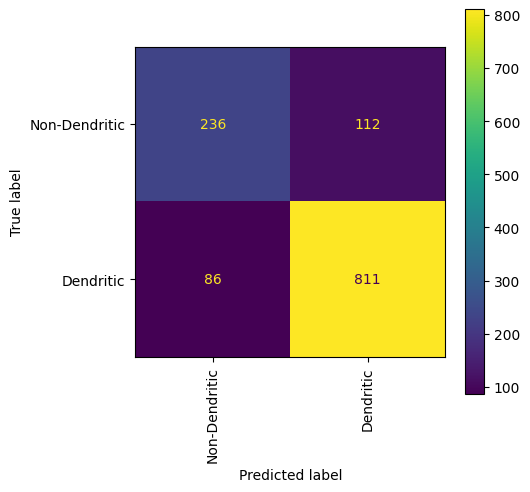

              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70       348
         1.0       0.88      0.90      0.89       897

    accuracy                           0.84      1245
   macro avg       0.81      0.79      0.80      1245
weighted avg       0.84      0.84      0.84      1245

Training Result - SVC(kernel='linear')
Training Accuracy for SVC(kernel='linear'): 93.01%
Validation Accuracy for SVC(kernel='linear'): 83.61%


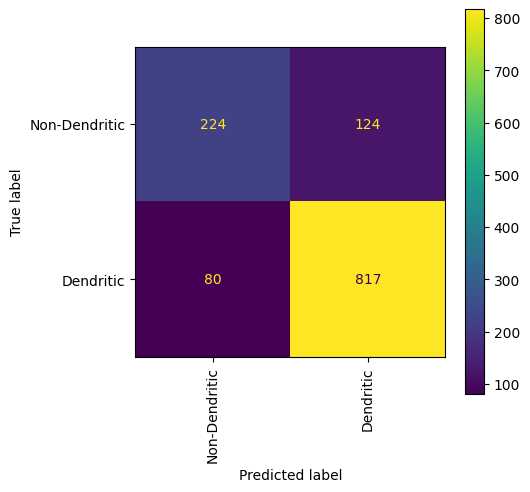

              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69       348
         1.0       0.87      0.91      0.89       897

    accuracy                           0.84      1245
   macro avg       0.80      0.78      0.79      1245
weighted avg       0.83      0.84      0.83      1245

Training Result - KNeighborsClassifier()
Training Accuracy for KNeighborsClassifier(): 93.99%
Validation Accuracy for KNeighborsClassifier(): 85.3%


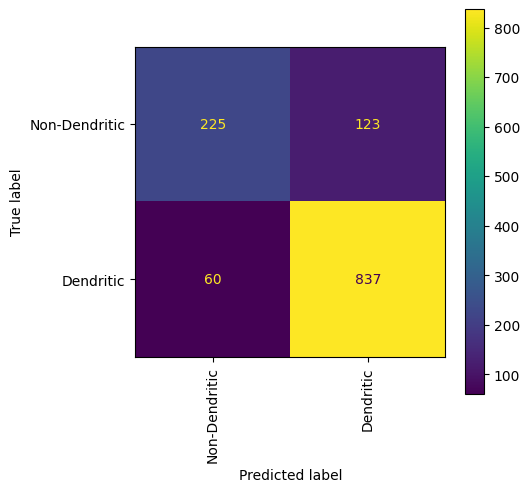

              precision    recall  f1-score   support

         0.0       0.79      0.65      0.71       348
         1.0       0.87      0.93      0.90       897

    accuracy                           0.85      1245
   macro avg       0.83      0.79      0.81      1245
weighted avg       0.85      0.85      0.85      1245

Training Result - RandomForestClassifier()
Training Accuracy for RandomForestClassifier(): 100.0%
Validation Accuracy for RandomForestClassifier(): 77.43%


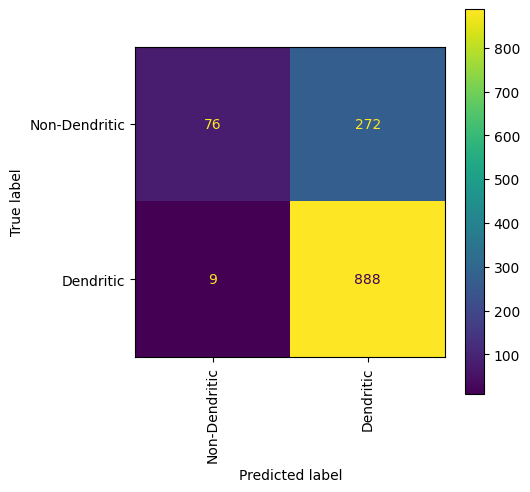

              precision    recall  f1-score   support

         0.0       0.89      0.22      0.35       348
         1.0       0.77      0.99      0.86       897

    accuracy                           0.77      1245
   macro avg       0.83      0.60      0.61      1245
weighted avg       0.80      0.77      0.72      1245



In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNeighborClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

models = [LogisticRegression(max_iter=1000), SVC(kernel='linear'), KNeighborClassifier(), RandomForestClassifier()]

# Define separate parameter grids for each model
param_grids = {
    LogisticRegression: {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},  # Parameters for LogisticRegression
    SVC: {'C': [0.01, 0.1], 'kernel': ['linear']},  # Parameters for SVC
    KNeighborClassifier: {'n_neighbors': [3, 5, 7, 9]},  # Parameters for KNeighborClassifier
    RandomForestClassifier: {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}  # Parameters for RandomForestClassifier
}

def compare_models_train_test():
  for model in models:

    X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
    #best_model.fit(X_train, y_train)

    # Get the appropriate parameter grid for the current model
    parameters = param_grids.get(type(model), {})

    # Fine-tune model
    grid_search = GridSearchCV(estimator=model,
                               param_grid=parameters, # Use the correct parameter grid
                               scoring='f1',
                               cv=5,
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Train the model
    best_model = grid_search.best_estimator_

    # Evaluate the model on the training set
    print("Training Result - {}".format(model))
    #print(evaluate_model(y_train, best_model.predict(X_train))) # Assuming evaluate_model is defined elsewhere


    # Evaluate the model on training data
    train_predictions = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_accuracy = train_accuracy*100
    train_accuracy = round(train_accuracy, 2)
    print(f"Training Accuracy for {model}: {train_accuracy}%")

    # Evaluate the model on validation data
    val_predictions = best_model.predict(X_test)
    val_accuracy = accuracy_score(y_test, val_predictions)
    val_accuracy = val_accuracy*100
    val_accuracy = round(val_accuracy, 2)
    print(f"Validation Accuracy for {model}: {val_accuracy}%")

    # Confusion matrix
    plot_confusion_matrix(y_test, val_predictions, label)
    print(classification_report(y_test, val_predictions))

compare_models_train_test()